In [1]:
%cd ..

/home/kimsin98/Adolescent/StructFunc


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
idx = pd.IndexSlice
SEED = 69

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
colors = sns.color_palette()

In [3]:
import statsmodels.api as sm
from utils import abcd, plotting
from utils.residual import residualize
from utils.combat import combat

covariates = abcd.load_covariates(simple_race=True)

# Functional connectivity

In [4]:
fcon, fc_extra = abcd.load_mri_data('fcon', dropna=True)

# sample 1 random scan from each family
fcon = (fcon.join(covariates['rel_family_id']).groupby('rel_family_id')
        .sample(1, random_state=SEED).drop('rel_family_id', axis=1))

print(len(fcon), 'subjects')

3694 subjects


## Scanner

In [5]:
abcd.SCAN_INFO

['mri_info_manufacturer',
 'mri_info_manufacturersmn',
 'mri_info_deviceserialnumber',
 'mri_info_softwareversion']

In [6]:
# fill in some baseline NA with year2
scan = fc_extra[abcd.SCAN_INFO].join(covariates['site_id']).fillna(method='bfill')

### Progressive residualize

Residualize each scanner confound one by one

In [7]:
results = {}

curr_features = fcon
for scan_conf in abcd.SCAN_INFO:
    results[scan_conf] = residualize(curr_features, sm.OLS, scan[scan_conf],
                                     return_results=True)
    curr_features = results[scan_conf].apply(lambda r: r.resid).T

mean: 0.0140, max: 0.0955


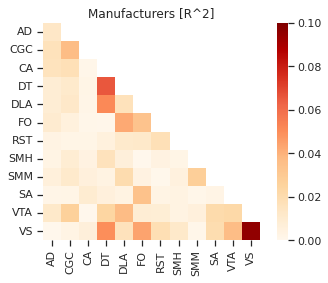

In [8]:
r2s = results['mri_info_manufacturer'].apply(lambda r: r.rsquared)

print(f'mean: {r2s.mean():.4f}, max: {r2s.max():.4f}')

with sns.axes_style('ticks'):
    ax = plotting.plot_fcon(r2s, cmap='OrRd', vmax=0.10, vmin=0)
ax.set_title('Manufacturers [R^2]')
plt.show()

mean: 0.0020, max: 0.0085


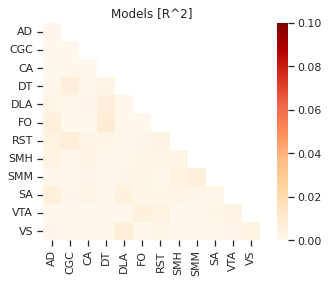

In [9]:
r2s = results['mri_info_manufacturersmn'].apply(lambda r: r.rsquared)

print(f'mean: {r2s.mean():.4f}, max: {r2s.max():.4f}')

with sns.axes_style('ticks'):
    ax = plotting.plot_fcon(r2s, cmap='OrRd', vmax=0.10, vmin=0)
ax.set_title('Models [R^2]')
plt.show()

mean: 0.0183, max: 0.0510


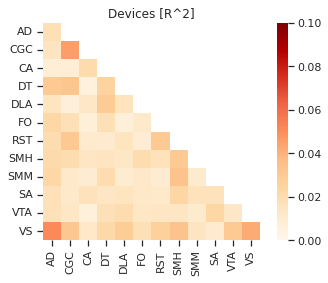

In [10]:
r2s = results['mri_info_deviceserialnumber'].apply(lambda r: r.rsquared)

print(f'mean: {r2s.mean():.4f}, max: {r2s.max():.4f}')

with sns.axes_style('ticks'):
    ax = plotting.plot_fcon(r2s, cmap='OrRd', vmax=0.10, vmin=0)
ax.set_title('Devices [R^2]')
plt.show()

mean: 0.0031, max: 0.0085


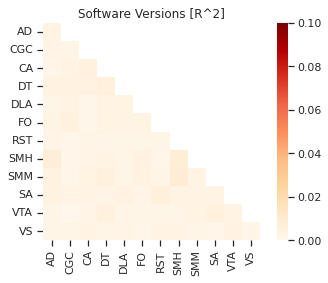

In [11]:
r2s = results['mri_info_softwareversion'].apply(lambda r: r.rsquared)

print(f'mean: {r2s.mean():.4f}, max: {r2s.max():.4f}')

with sns.axes_style('ticks'):
    ax = plotting.plot_fcon(r2s, cmap='OrRd', vmax=0.10, vmin=0)
ax.set_title('Software Versions [R^2]')
plt.show()

### Specific variables

In [12]:
scan_groups = scan.loc[fcon.index].groupby('mri_info_manufacturer')

#### SIEMENS

In [13]:
scan_siemens = scan_groups.get_group('SIEMENS')

In [14]:
scan_siemens['mri_info_manufacturersmn'].value_counts()

Prisma_fit    1191
Prisma        1101
Name: mri_info_manufacturersmn, dtype: int64

In [15]:
scan_siemens['mri_info_softwareversion'].value_counts()

syngo MR E11    2292
Name: mri_info_softwareversion, dtype: int64

mean: 0.0017, max: 0.0091


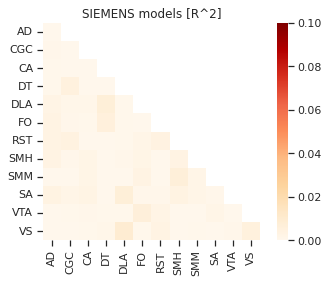

In [16]:
result = residualize(fcon, sm.OLS, scan_siemens['mri_info_manufacturersmn'],
                     return_results=True)
r2s = result.apply(lambda r: r.rsquared)

print(f'mean: {r2s.mean():.4f}, max: {r2s.max():.4f}')

with sns.axes_style('ticks'):
    ax = plotting.plot_fcon(r2s, cmap='OrRd', vmax=0.10, vmin=0)
ax.set_title('SIEMENS models [R^2]')
plt.show()

mean: 0.0194, max: 0.0459


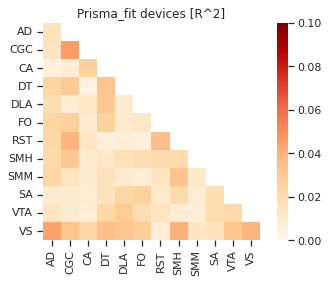

In [17]:
result = residualize(
    fcon, sm.OLS,
    scan_siemens.loc[scan_siemens['mri_info_manufacturersmn'] == 'Prisma_fit',
                     'mri_info_deviceserialnumber'],
    return_results=True
)
r2s = result.apply(lambda r: r.rsquared)

print(f'mean: {r2s.mean():.4f}, max: {r2s.max():.4f}')

with sns.axes_style('ticks'):
    ax = plotting.plot_fcon(r2s, cmap='OrRd', vmax=0.10, vmin=0)
ax.set_title('Prisma_fit devices [R^2]')
plt.show()

#### GE

In [18]:
scan_ge = scan_groups.get_group('GE MEDICAL SYSTEMS')

In [19]:
scan_ge['mri_info_manufacturersmn'].value_counts()

DISCOVERY MR750    971
Name: mri_info_manufacturersmn, dtype: int64

In [20]:
scan_ge['mri_info_softwareversion'].value_counts()

25\LX\MR Software release:DV25.0_R02_1549.b    447
27\LX\MR Software release:DV26.0_R02_1810.b    233
27\LX\MR Software release:DV26.0_R01_1725.a    227
27\LX\MR Software release:DV26.0_R03_1831.b     52
27\LX\MR Software release:DV25.1_R01_1617.b     12
Name: mri_info_softwareversion, dtype: int64

mean: 0.0105, max: 0.0388


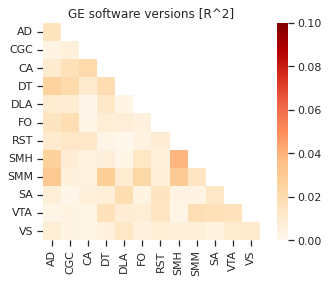

In [21]:
result = residualize(fcon, sm.OLS, scan_ge['mri_info_softwareversion'],
                     return_results=True)
r2s = result.apply(lambda r: r.rsquared)

print(f'mean: {r2s.mean():.4f}, max: {r2s.max():.4f}')

with sns.axes_style('ticks'):
    ax = plotting.plot_fcon(r2s, cmap='OrRd', vmax=0.10, vmin=0)
ax.set_title('GE software versions [R^2]')
plt.show()

mean: 0.0181, max: 0.0555


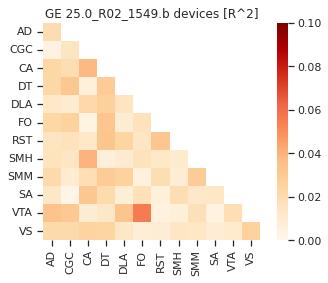

In [22]:
result = residualize(
    fcon, sm.OLS,
    scan_ge.loc[scan_ge['mri_info_softwareversion'].str.endswith('DV25.0_R02_1549.b'),
                'mri_info_deviceserialnumber'],
    return_results=True
)
r2s = result.apply(lambda r: r.rsquared)

print(f'mean: {r2s.mean():.4f}, max: {r2s.max():.4f}')

with sns.axes_style('ticks'):
    ax = plotting.plot_fcon(r2s, cmap='OrRd', vmax=0.10, vmin=0)
ax.set_title('GE 25.0_R02_1549.b devices [R^2]')
plt.show()

#### Philips

In [23]:
scan_philips = scan_groups.get_group('Philips Medical Systems')

In [24]:
scan_philips['mri_info_manufacturersmn'].value_counts()

Achieva dStream    303
Ingenia            128
Name: mri_info_manufacturersmn, dtype: int64

In [25]:
scan_philips['mri_info_softwareversion'].value_counts()

5.3.0\5.3.0.0    116
5.3.1\5.3.1.0     76
5.4.0\5.4.0.1     63
5.3.0\5.3.0.3     60
5.4.1\5.4.1.1     49
5.3.1\5.3.1.2     35
5.3.1\5.3.1.1     23
5.3.1\5.3.1.3      9
Name: mri_info_softwareversion, dtype: int64

mean: 0.0078, max: 0.0537


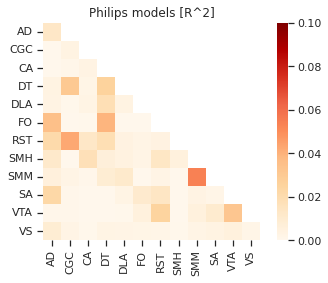

In [26]:
result = residualize(fcon, sm.OLS, scan_philips['mri_info_manufacturersmn'],
                     return_results=True)
r2s = result.apply(lambda r: r.rsquared)

print(f'mean: {r2s.mean():.4f}, max: {r2s.max():.4f}')

with sns.axes_style('ticks'):
    ax = plotting.plot_fcon(r2s, cmap='OrRd', vmax=0.10, vmin=0)
ax.set_title('Philips models [R^2]')
plt.show()

mean: 0.0281, max: 0.0897


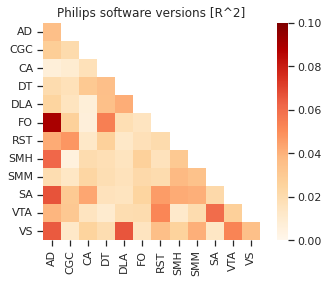

In [27]:
result = residualize(fcon, sm.OLS, scan_philips['mri_info_softwareversion'],
                     return_results=True)
r2s = result.apply(lambda r: r.rsquared)

print(f'mean: {r2s.mean():.4f}, max: {r2s.max():.4f}')

with sns.axes_style('ticks'):
    ax = plotting.plot_fcon(r2s, cmap='OrRd', vmax=0.10, vmin=0)
ax.set_title('Philips software versions [R^2]')
plt.show()

### Single-site

In [28]:
scan_site04 = scan.loc[fcon.index].query('site_id == "site04"')
scan_site04.value_counts()

mri_info_manufacturer  mri_info_manufacturersmn  mri_info_deviceserialnumber  mri_info_softwareversion                     site_id
GE MEDICAL SYSTEMS     DISCOVERY MR750           HASH4b0b8b05                 25\LX\MR Software release:DV25.0_R02_1549.b  site04     103
                                                                              27\LX\MR Software release:DV26.0_R02_1810.b  site04      93
                                                 HASHfeb7e81a                 25\LX\MR Software release:DV25.0_R02_1549.b  site04      61
                                                                              27\LX\MR Software release:DV26.0_R02_1810.b  site04      40
dtype: int64

mean: 0.0024, max: 0.0158


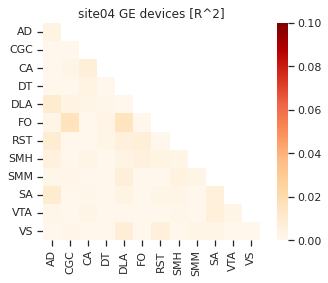

In [29]:
result = residualize(fcon, sm.OLS, scan_site04['mri_info_deviceserialnumber'],
                     return_results=True)
r2s = result.apply(lambda r: r.rsquared)

print(f'mean: {r2s.mean():.4f}, max: {r2s.max():.4f}')

with sns.axes_style('ticks'):
    ax = plotting.plot_fcon(r2s, cmap='OrRd', vmax=0.10, vmin=0)
ax.set_title('site04 GE devices [R^2]')
plt.show()

mean: 0.0075, max: 0.0481


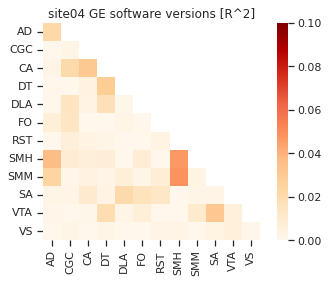

In [30]:
result = residualize(fcon, sm.OLS, scan_site04['mri_info_softwareversion'],
                     return_results=True)
r2s = result.apply(lambda r: r.rsquared)

print(f'mean: {r2s.mean():.4f}, max: {r2s.max():.4f}')

with sns.axes_style('ticks'):
    ax = plotting.plot_fcon(r2s, cmap='OrRd', vmax=0.10, vmin=0)
ax.set_title('site04 GE software versions [R^2]')
plt.show()

### Best set by adjusted R2 (LONG)

In [31]:
def powerset(iterable):
    from itertools import chain, combinations
    
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(1, 1 + len(s)))

def adjusted_r2s(confound_set):
    warnings.simplefilter(action='ignore', category=FutureWarning)
    try:
        result = residualize(fcon, sm.OLS, scan[list(confound_set)], return_results=True)
        adj_r2s = result.apply(lambda r: r.rsquared_adj)
        return adj_r2s.rename(str(confound_set))
    except np.linalg.LinAlgError:
        return None

from joblib import Parallel, delayed

adj_r2s = Parallel(n_jobs=4)(delayed(adjusted_r2s)(c) for c in powerset(scan.columns))
adj_r2s = pd.concat(adj_r2s, axis=1).T

In [32]:
adj_r2s.mean(axis=1).sort_values(ascending=False).head()

('mri_info_softwareversion', 'site_id')                                                 0.026668
('mri_info_manufacturer', 'mri_info_softwareversion', 'site_id')                        0.026308
('mri_info_deviceserialnumber',)                                                        0.026272
('mri_info_manufacturer', 'mri_info_deviceserialnumber', 'mri_info_softwareversion')    0.026144
('mri_info_deviceserialnumber', 'mri_info_softwareversion')                             0.025641
dtype: float64

In [33]:
adj_r2s.median(axis=1).sort_values(ascending=False).head()

('mri_info_deviceserialnumber', 'mri_info_softwareversion')                                0.020618
('mri_info_manufacturer', 'mri_info_deviceserialnumber', 'mri_info_softwareversion')       0.020501
('mri_info_softwareversion', 'site_id')                                                    0.020279
('mri_info_deviceserialnumber',)                                                           0.020150
('mri_info_manufacturersmn', 'mri_info_deviceserialnumber', 'mri_info_softwareversion')    0.019725
dtype: float64

In [34]:
adj_r2s.max(axis=1).sort_values(ascending=False).head()

('mri_info_manufacturer', 'site_id')                           0.129883
('mri_info_deviceserialnumber',)                               0.129772
('mri_info_manufacturersmn', 'site_id')                        0.129755
('mri_info_softwareversion', 'site_id')                        0.129551
('mri_info_manufacturersmn', 'mri_info_deviceserialnumber')    0.129497
dtype: float64

### ComBat

In [35]:
scan_confounds = ['mri_info_deviceserialnumber', 'mri_info_softwareversion']

In [36]:
batch = fc_extra[scan_confounds].apply(tuple, axis=1)
covars = fc_extra[['meanmotion']].join(covariates[['interview_age', 'sex', 'race', 'hisp']])
fcon_combat = combat(fcon, batch, covars, n_procs=4)

fcon_regress = residualize(fcon, sm.OLS, scan[scan_confounds])

In [37]:
from scipy.stats import pearsonr

r_fcon_combat = fcon.combine(fcon_combat, lambda x,y: pearsonr(x,y)[0]).iloc[0,:]
r_fcon_regress = fcon.combine(fcon_regress, lambda x,y: pearsonr(x,y)[0]).iloc[0,:]
r_combat_regress = fcon_regress.combine(fcon_combat, lambda x,y: pearsonr(x,y)[0]).iloc[0,:]

In [38]:
r_fcon_combat.describe()

count    78.000000
mean      0.981816
std       0.006396
min       0.949951
25%       0.979055
50%       0.982986
75%       0.985929
max       0.991107
Name: (NDAR_INV0N0JE94U, 2_year_follow_up_y_arm_1), dtype: float64

In [39]:
r_fcon_regress.describe()

count    78.000000
mean      0.980713
std       0.010829
min       0.926527
25%       0.975814
50%       0.984032
75%       0.987490
max       0.994703
Name: (NDAR_INV0N0JE94U, 2_year_follow_up_y_arm_1), dtype: float64

In [40]:
r_combat_regress.describe()

count    78.000000
mean      0.989721
std       0.002679
min       0.982274
25%       0.987805
50%       0.989761
75%       0.991834
max       0.994364
Name: (NDAR_INV0N0JE94U, 2_year_follow_up_y_arm_1), dtype: float64

## Motion-Age

mean: 0.0106, max: 0.0836


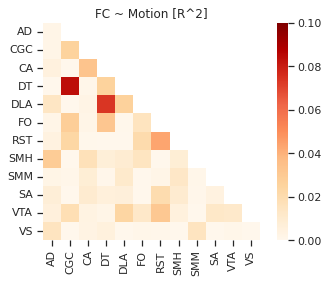

In [41]:
result = residualize(fcon, sm.OLS, fc_extra['meanmotion'],
                     return_results=True)
r2s = result.apply(lambda r: r.rsquared)

print(f'mean: {r2s.mean():.4f}, max: {r2s.max():.4f}')

with sns.axes_style('ticks'):
    ax = plotting.plot_fcon(r2s, cmap='OrRd', vmax=0.10, vmin=0)
ax.set_title('FC ~ Motion [R^2]')
plt.show()

In [42]:
result = residualize(fc_extra['meanmotion'], sm.OLS,
                     covariates['interview_age'],
                     return_results=True)
r2 = result.squeeze().rsquared

print(f'Motion ~ Age: {r2:.4f}')

Motion ~ Age: 0.0431


mean: 0.0030, max: 0.0254


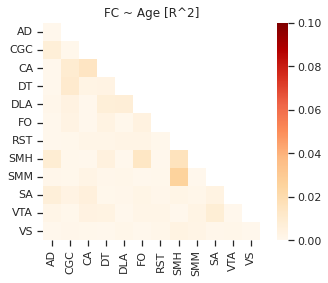

In [43]:
result = residualize(fcon, sm.OLS, covariates['interview_age'],
                     return_results=True)
r2s = result.apply(lambda r: r.rsquared)

print(f'mean: {r2s.mean():.4f}, max: {r2s.max():.4f}')

with sns.axes_style('ticks'):
    ax = plotting.plot_fcon(r2s, cmap='OrRd', vmax=0.10, vmin=0)
ax.set_title('FC ~ Age [R^2]')
plt.show()

mean: 0.0127, max: 0.0857


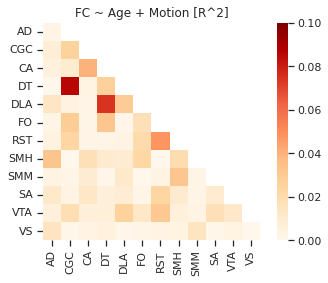

In [44]:
result = residualize(
    fcon, sm.OLS,
    fc_extra[['meanmotion']].join(covariates['interview_age']),
    return_results=True
)
r2s = result.apply(lambda r: r.rsquared)

print(f'mean: {r2s.mean():.4f}, max: {r2s.max():.4f}')

with sns.axes_style('ticks'):
    ax = plotting.plot_fcon(r2s, cmap='OrRd', vmax=0.10, vmin=0)
ax.set_title('FC ~ Age + Motion [R^2]')
plt.show()

## Demographic

In [45]:
def freq_code(col):
    code = col.value_counts() / len(col)
    return col.map(code).dropna()

demo = {'Sex': covariates['sex'],
        'Race': covariates[['race', 'hisp']],
        'Income': freq_code(covariates['comb_income.3level']),
        'Education': freq_code(covariates['highest_ed.5level']),
        'Married': covariates['married']}

results = {cov: residualize(fcon, sm.OLS, covars, return_results=True)
           for cov, covars in demo.items()}

Sex       | mean: 0.0034, max: 0.0228
Race      | mean: 0.0088, max: 0.0499
Income    | mean: 0.0023, max: 0.0163
Education | mean: 0.0022, max: 0.0178
Married   | mean: 0.0031, max: 0.0196


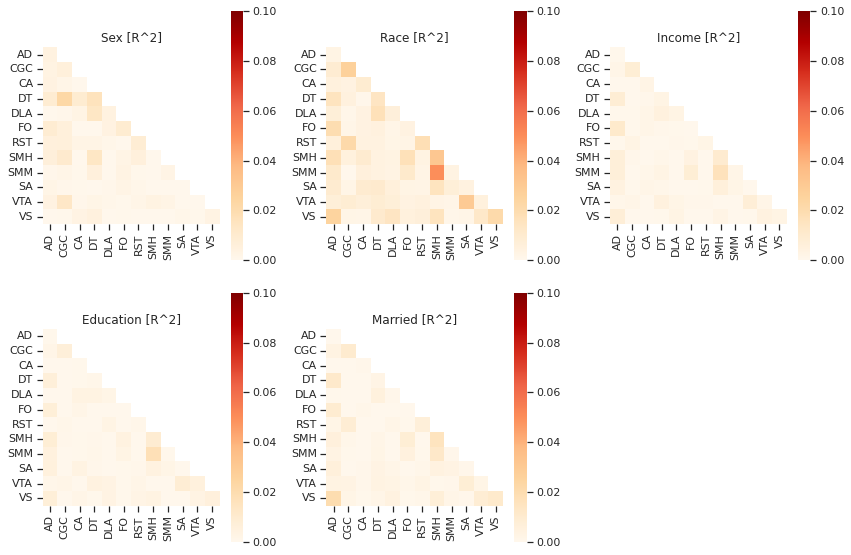

In [46]:
r2ss = pd.DataFrame({cov: result.apply(lambda r: r.rsquared)
                     for cov, result in results.items()}).T

fig = plt.figure(figsize=(12, 8))
for i, (cov, r2s) in enumerate(r2ss.iterrows()):
    print(f'{cov:9} | mean: {r2s.mean():.4f}, max: {r2s.max():.4f}')
    
    with sns.axes_style('ticks'):
        ax = fig.add_subplot(2, 3, i+1)
        ax = plotting.plot_fcon(r2s, cmap='OrRd', vmax=0.10, vmin=0, ax=ax)
    ax.set_title(f'{cov} [R^2]')

plt.tight_layout()
plt.show()

# Structural connectivity

In [7]:
scon, sc_extra = abcd.load_mri_data('scon', dropna=True)

# sample 1 random scan from each family
scon = (scon.join(covariates['rel_family_id']).groupby('rel_family_id')
        .sample(1, random_state=SEED).drop('rel_family_id', axis=1))

print(len(scon), 'subjects')

4090 subjects


## Scanner

In [42]:
# fill in some baseline NA with year2
scan = sc_extra[abcd.SCAN_INFO].join(covariates['site_id']).fillna(method='bfill')

### Progressive residualize

In [43]:
results = {}

curr_features = scon
for scan_conf in abcd.SCAN_INFO:
    results[scan_conf] = residualize(curr_features, sm.OLS, scan[scan_conf],
                                     return_results=True)
    curr_features = results[scan_conf].apply(lambda r: r.resid).T

Manufact  | mean: 0.2157, max: 0.3612
Model     | mean: 0.0149, max: 0.0538
Device    | mean: 0.0398, max: 0.0604
Software  | mean: 0.0185, max: 0.0544


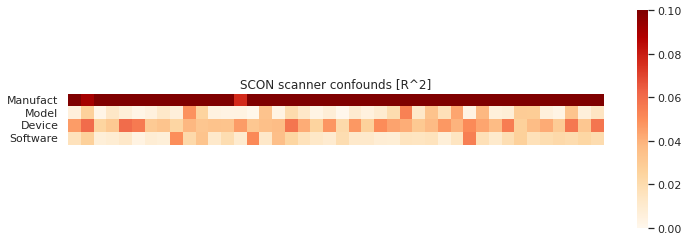

In [44]:
r2ss = [results[scan_conf].apply(lambda r: r.rsquared)
        for scan_conf in abcd.SCAN_INFO]
r2ss = pd.concat(r2ss, axis=1, keys=['Manufact', 'Model', 'Device', 'Software']).T

for conf, r2s in r2ss.iterrows():
    print(f'{conf:9} | mean: {r2s.mean():.4f}, max: {r2s.max():.4f}')

fig, ax = plt.subplots(figsize=(12,4))
ax = sns.heatmap(r2ss, square=True, cmap='OrRd', vmax=0.10, vmin=0, ax=ax)
ax.set_title('SCON scanner confounds [R^2]')
ax.set_xticks([])
plt.show()

### Best set by adjusted R2 (LONG)

In [ ]:
def powerset(iterable):
    from itertools import chain, combinations
    
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(1, 1 + len(s)))

def adjusted_r2s(confound_set):
    warnings.simplefilter(action='ignore', category=FutureWarning)
    try:
        result = residualize(scon, sm.OLS, scan[list(confound_set)], return_results=True)
        adj_r2s = result.apply(lambda r: r.rsquared_adj)
        return adj_r2s.rename(str(confound_set))
    except np.linalg.LinAlgError:
        return None

from joblib import Parallel, delayed

adj_r2s = Parallel(n_jobs=4)(delayed(adjusted_r2s)(c) for c in powerset(scan.columns))
adj_r2s = pd.concat(adj_r2s, axis=1).T

In [51]:
adj_r2s.mean(axis=1).sort_values(ascending=False).head()

('mri_info_manufacturer', 'mri_info_softwareversion', 'site_id')                           0.266331
('mri_info_softwareversion', 'site_id')                                                    0.266331
('mri_info_manufacturersmn', 'mri_info_deviceserialnumber', 'mri_info_softwareversion')    0.254397
('mri_info_deviceserialnumber',)                                                           0.252948
('mri_info_manufacturersmn', 'site_id')                                                    0.248240
dtype: float64

In [52]:
adj_r2s.median(axis=1).sort_values(ascending=False).head()

('mri_info_manufacturer', 'mri_info_softwareversion', 'site_id')                           0.259850
('mri_info_softwareversion', 'site_id')                                                    0.259850
('mri_info_manufacturersmn', 'mri_info_deviceserialnumber', 'mri_info_softwareversion')    0.256034
('mri_info_deviceserialnumber',)                                                           0.249681
('mri_info_manufacturer', 'site_id')                                                       0.243711
dtype: float64

In [53]:
adj_r2s.max(axis=1).sort_values(ascending=False).head()

('mri_info_softwareversion', 'site_id')                                                    0.399418
('mri_info_manufacturer', 'mri_info_softwareversion', 'site_id')                           0.399418
('mri_info_manufacturer', 'mri_info_deviceserialnumber', 'mri_info_softwareversion')       0.394907
('mri_info_manufacturersmn', 'mri_info_deviceserialnumber', 'mri_info_softwareversion')    0.392600
('mri_info_deviceserialnumber',)                                                           0.383146
dtype: float64

## Motion-Age

mean: 0.0614, max: 0.1500


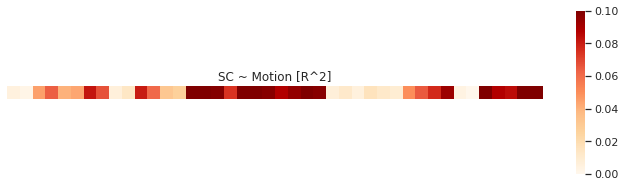

In [5]:
result = residualize(scon, sm.OLS, sc_extra['meanmotion'],
                     return_results=True)
r2s = result.apply(lambda r: r.rsquared)
r2ss = r2s.rename('Motion').to_frame().T

print(f'mean: {r2s.mean():.4f}, max: {r2s.max():.4f}')

fig, ax = plt.subplots(figsize=(12,3))
ax = sns.heatmap(r2ss, square=True, cmap='OrRd', vmax=0.10, vmin=0, ax=ax)
ax.set_title('SC ~ Motion [R^2]')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [46]:
result = residualize(sc_extra['meanmotion'], sm.OLS, covariates['interview_age'],
                     return_results=True)
r2 = result.squeeze().rsquared

print(f'Motion ~ Age: {r2:.4f}')

Motion ~ Age: 0.0292


mean: 0.0228, max: 0.0480


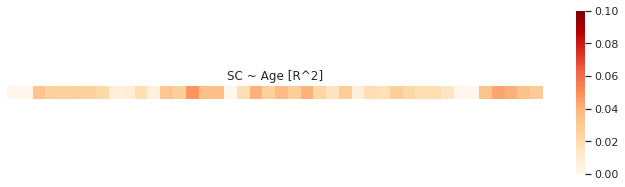

In [47]:
result = residualize(scon, sm.OLS, covariates['interview_age'],
                     return_results=True)
r2s = result.apply(lambda r: r.rsquared)
r2ss = r2s.rename('Motion').to_frame().T

print(f'mean: {r2s.mean():.4f}, max: {r2s.max():.4f}')

fig, ax = plt.subplots(figsize=(12,3))
ax = sns.heatmap(r2ss, square=True, cmap='OrRd', vmax=0.10, vmin=0, ax=ax)
ax.set_title('SC ~ Age [R^2]')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

mean: 0.0745, max: 0.1550


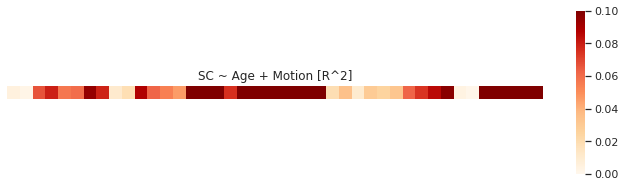

In [48]:
result = residualize(
    scon, sm.OLS,
    sc_extra[['meanmotion']].join(covariates['interview_age']),
    return_results=True
)
r2s = result.apply(lambda r: r.rsquared)
r2ss = r2s.rename('Motion').to_frame().T

print(f'mean: {r2s.mean():.4f}, max: {r2s.max():.4f}')

fig, ax = plt.subplots(figsize=(12,3))
ax = sns.heatmap(r2ss, square=True, cmap='OrRd', vmax=0.10, vmin=0, ax=ax)
ax.set_title('SC ~ Age + Motion [R^2]')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

## Demographic

In [9]:
def freq_code(col):
    code = col.value_counts() / len(col)
    return col.map(code).dropna()

demo = {'Sex': covariates['sex'],
        'Race': covariates[['race', 'hisp']],
        'Income': freq_code(covariates['comb_income.3level']),
        'Education': freq_code(covariates['highest_ed.5level']),
        'Married': covariates['married']}

results = {cov: residualize(scon, sm.OLS, covars, return_results=True)
           for cov, covars in demo.items()}

Sex       | mean: 0.0027, max: 0.0117
Race      | mean: 0.0077, max: 0.0216
Income    | mean: 0.0008, max: 0.0032
Education | mean: 0.0006, max: 0.0037
Married   | mean: 0.0008, max: 0.0029


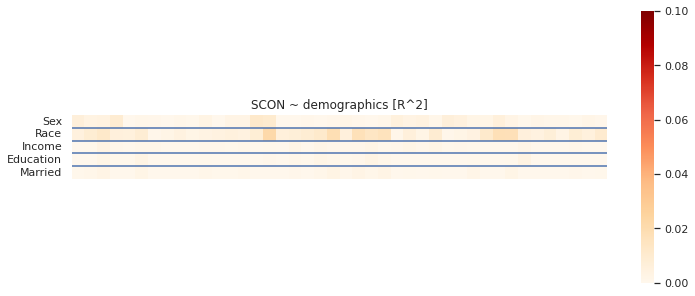

In [10]:
r2ss = pd.DataFrame({cov: result.apply(lambda r: r.rsquared)
                     for cov, result in results.items()}).T

for cov, r2s in r2ss.iterrows():
    print(f'{cov:9} | mean: {r2s.mean():.4f}, max: {r2s.max():.4f}')

fig, ax = plt.subplots(figsize=(12,5))
ax = sns.heatmap(r2ss, square=True, cmap='OrRd', vmax=0.10, vmin=0, ax=ax)
ax.set_title('SCON ~ demographics [R^2]')
ax.set_xticks([])
ax.hlines(np.arange(1, len(r2ss)), *ax.get_xlim())
plt.show()

# TODO

* age-motion mediation analysis
* overfitting?
* bootstrap + violin plot
* Hierarchical Bayesian

[Marek-IdentifyingReproducible-2019](https://doi.org/10.1016/j.dcn.2019.100706) Replication
* subject similarity
* multidimensional scaling